In [0]:
import numpy as np
import networkx as nx
import pandas as pd
import random
import functools
from similarities import *
from itertools import combinations 
import math

In [0]:
def load_restaurant_dataset():
    path = 'dataset_ubicomp2013_checkins.txt'
#     lines = (line.decode('utf-8') for line in path)
    infile = open(path, 'r')
    a = set()
    b = set()
    edges = []
    for line in infile:
        s=line.strip().split(None)
        u=-1*int(s.pop(0)) -10
        v=int(s.pop(0))
        a.add(u)
        b.add(v)
        edges.append((u,v))
    top_nodes = {}
    bottom_nodes = {}
    count = 0 
    for x in a:
        top_nodes[x] = count
        count = count + 1
    count  = 0    
    for y in b:
        bottom_nodes[y] = count
        count  = count + 1
    
    A = np.zeros((len(a),len(b)))
    for edge in edges:
        e1 = top_nodes[edge[0]]
        e2 = bottom_nodes[edge[1]]
        A[e1, e2] = 1
    
    A = np.dot(A,A.T)
#     print(A[:35,:35])
    for i in range(0,A.shape[0]):  #making numpy matrix undirected graph type
        for j in range(0,A.shape[1]):
            if i == j :
                A[i,j] = 0
            else:
                if A[i,j] > 0:
                    A[i,j] = 1
                    
    G=nx.from_numpy_matrix(A)
    return G

In [0]:
def apply(graph, func):
    non_edges = nx.non_edges(graph)
    return ((u, v, func(u, v)) for u, v in non_edges)

def CN_score(graph,u,v):
        return len(list(w for w in graph[u] if w in graph[v] and w not in (u, v)))

def common_neighbors_score(graph): 
    non_edges = nx.non_edges(graph)
    def score(u,v):
        return len(list(w for w in graph[u] if w in graph[v] and w not in (u, v)))

    return ((u, v, score(u, v)) for u, v in non_edges) 


def AA_score(graph, u, v):
        return sum(1 / math.log(graph.degree(w))for w in nx.common_neighbors(graph, u, v))

def adamic_adar_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u, v):
        return sum(1 / math.log(graph.degree(w))for w in nx.common_neighbors(graph, u, v))

    return ((u, v, score(u, v)) for u, v in non_edges) 

def PA_score(graph, u, v):
    return (graph.degree(u) * graph.degree(v))


def preferential_attachment_score(graph):
    non_edges = nx.non_edges(graph)
    return ((u, v, graph.degree(u) * graph.degree(v)) for u, v in non_edges)


def RA_score(graph, u, v):
        return sum(1 / graph.degree(w) for w in nx.common_neighbors(graph, u, v))

def resource_allocation_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u, v):def friends_measure(graph, u, v):  #heuristic for katz
    score = 0
    for x in graph[u]:
        for y in graph[v]:
            if x == y:
                score = score + 1
            elif graph.has_edge(x,y):
                score = score + 1
    return score
        return sum(1 / graph.degree(w) for w in nx.common_neighbors(graph, u, v))
    return apply(graph, score, non_edges) 


def JC_score(graph, u, v):
        union_size = len(set(graph[u]) | set(graph[v]))
        if union_size == 0:
            return 0
        else:
            return len(list(nx.common_neighbors(graph, u, v))) / union_size

def jaccard_coefficient_score(graph):
    non_edges = nx.non_edges(graph)
    def score(u,v):
        union_size = len(set(graph[u]) | set(graph[v]))
        if union_size == 0:
            return 0
        else:
            return len(list(nx.common_neighbors(graph, u, v))) / union_size

    return apply(graph,score,non_edges)    



def katz_score(graph,beta=0.004):
    non_edges = nx.non_edges(graph)
    A = nx.to_numpy_matrix(graph)
    # print(A)
    w, v = np.linalg.eigh(A)
    lambda1 = max([abs(x) for x in w])   # beta should be less than 1/lambda1
    # print(1/lambda1)
    if beta >= 1/lambda1 :
        raise ValueError('beta should be less than 1/lambda, lambda being the eigenvalue with largest magnitude')
    I = np.eye(A.shape[0])
    S = np.linalg.inv(I - beta * A) - I
    return S


def RP_score(graph, u, v):
    return rooted_pagerank_score(graph,u)[v] + rooted_pagerank_score(graph,v)[u]


def rooted_pagerank_score(graph, root_node, alpha = 0.85, max_iter = 100):
    if not graph.is_directed():
        D = graph.to_directed()
    else:
         D = graph
    H = nx.stochastic_graph(D)
    n = len(graph.nodes())
    H = nx.to_numpy_matrix(H).transpose()
    x = np.full((n,1),1.0 / n)
    v = np.full((n,1),0.0)
    nodes = D.nodes()
    index = 0
    for node in nodes:
        # print(node)
        # print(root_node)
        # print(index)
        if node == root_node:
            # print(1-alpha)
            v[index][0] = 1 - alpha
            break
        index = index +  1
    # print(v)

    for _ in range(max_iter):
        x = np.add(alpha*np.dot(H,x),v) # x = alpha*H*x + (1-alpha)*v

    x = np.squeeze(np.asarray(x))
    x = x /	np.sum(x)
    return dict(zip(graph.nodes(), x))
  


In [0]:

graph = load_restaurant_dataset()

nodes = list(graph.nodes)
# print(nx.info(graph))
non_edges = list(nx.non_edges(graph))
edges = list(nx.edges(graph))
# print((non_edges))
m = len(edges)

# print(JC_score(graph, 1, 2))
# print(m)
marked_non_edges = random.sample(non_edges, m)
# print(len(marked_non_edges))
is_edge = [ 1 ] * m + [ 0 ] * m
    # print(len(is_edge))
df_dict = {}
df_dict['is_edge'] = is_edge

# df = pd.DataFrame(df_dict)
# print(df)
cn_scores = [ CN_score(graph,u,v) for (u,v) in edges ] + [ CN_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['CN_score'] = cn_scores
print("Added CN scores....")

aa_scores = [ AA_score(graph,u,v) for (u,v) in edges ] + [ AA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['AA_score'] = aa_scores
print("Added AA scores....")

pa_scores = [ PA_score(graph,u,v) for (u,v) in edges ] + [ PA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['PA_score'] = pa_scores
print("Added PA scores....")

ra_scores = [ RA_score(graph,u,v) for (u,v) in edges ] + [ RA_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['RA_score'] = ra_scores
print("Added RA scores....")

jc_scores = [ JC_score(graph,u,v) for (u,v) in edges ] + [ JC_score(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['JC_score'] = jc_scores
print("Added JC scores....")

@functools.lru_cache(maxsize=None)
def RP_calc(u):
    return rooted_pagerank_score(graph,u)

def RP_compute(u,v):
    return RP_calc(u)[v] + RP_calc(v)[u]

print(RP_compute(1,2))
print(RP_compute(1,3))
rp_scores = [ RP_compute(u, v) for (u,v) in edges ] + [ RP_compute(u,v) for (u,v) in marked_non_edges ]
df_dict['RP_score'] = rp_scores
print("Added RP scores....")



Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
0.0013310181040082623
0.0012014958960724826
Added RP scores....


In [0]:
katz_matrix = katz_score(graph)

In [0]:
katz_matrix.shape

(2060, 2060)

In [0]:
# df = pd.DataFrame(df_dict)
# print(df)
katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in marked_non_edges ]
df_dict['KATZ_score'] = katz_scores
print("Added KATZ scores....")

  

Added KATZ scores....


In [0]:
# df = pd.DataFrame(df_dict)
# print(df)

        is_edge  CN_score   AA_score  ...  JC_score      RP_score    KATZ_score
0             1        34   6.958747  ...  0.097421  4.358959e-03  4.994421e-03
1             1        65  13.525381  ...  0.408805  5.524035e-03  5.535159e-03
2             1        29   5.956897  ...  0.142157  4.177083e-03  4.741384e-03
3             1        67  13.909497  ...  0.236749  5.277321e-03  5.689136e-03
4             1        24   4.961426  ...  0.224299  6.010303e-03  4.486023e-03
5             1        62  12.878619  ...  0.659574  6.725171e-03  5.384969e-03
6             1        63  13.094766  ...  0.496063  5.853248e-03  5.449215e-03
7             1        71  14.709681  ...  0.181122  5.615424e-03  5.947782e-03
8             1        69  14.373659  ...  0.336585  5.401062e-03  5.642469e-03
9             1        67  13.920414  ...  0.401198  5.504318e-03  5.568596e-03
10            1        30   6.181744  ...  0.193548  4.544521e-03  4.680223e-03
11            1        63  13.052430  ..

In [0]:
df_dict['node1'] = [ x[0] for x in edges ] + [ x[0] for x in marked_non_edges]
df_dict['node2'] = [ x[1] for x in edges ] + [ x[1] for x in marked_non_edges]

In [0]:
is_same_community = [ nx.has_path(graph,u,v) for (u,v) in edges ] + [ nx.has_path(graph,u,v) for (u,v) in marked_non_edges ]

In [0]:
is_same_community

In [0]:
df_dict['in_same_community'] = is_same_community


In [0]:
def friends_measure(graph, u, v):  #heuristic for katz
    score = 0
    for x in graph[u]:
        for y in graph[v]:
            if x == y:
                score = score + 1
            elif graph.has_edge(x,y):
                score = score + 1
    return score

In [0]:
friends_measures = [ friends_measure(graph,u,v) for (u,v) in edges ] + [ friends_measure(graph,u,v) for (u,v) in marked_non_edges ]
df_dict['friends_measure'] = friends_measures
print("Added friends measure scores....")

Added friends measure scores....


In [0]:
df = pd.DataFrame(df_dict)
print(df)

        is_edge  CN_score   AA_score  ...  node2  in_same_community  friends_measure
0             1        34   6.958747  ...     21               True             3735
1             1        65  13.525381  ...     83               True             4980
2             1        29   5.956897  ...     89               True             2417
3             1        67  13.909497  ...    110               True             5818
4             1        24   4.961426  ...    125               True             1033
5             1        62  12.878619  ...    170               True             4214
6             1        63  13.094766  ...    171               True             4580
7             1        71  14.709681  ...    176               True             7197
8             1        69  14.373659  ...    181               True             5336
9             1        67  13.920414  ...    197               True             5016
10            1        30   6.181744  ...    200               Tr

**SHUFFLING DATASET**

In [0]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [0]:
df_shuffled

,is_edge,CN_score,AA_score,PA_score,RA_score,JC_score,RP_score,KATZ_score,node1,node2,in_same_community,friends_measure
0,1,24,5.095959,8170,0.246068,0.114833,0.005835,4.528523e-03,1934,1994,True,1392
1,1,9,1.954881,1640,0.103036,0.125000,0.007467,4.171927e-03,1456,1979,True,272
2,1,89,17.742285,26865,0.615847,0.363265,0.004650,6.444240e-03,616,919,True,9095
3,0,0,0.000000,476,0.000000,0.000000,0.000348,4.126282e-06,248,1958,True,32
4,1,32,6.737502,17702,0.320277,0.132780,0.004057,4.824087e-03,15,578,True,2816
5,0,1,0.212335,2418,0.009009,0.009259,0.000629,3.659287e-05,788,1032,True,175
6,0,1,0.177809,928,0.003610,0.008130,0.000674,3.527636e-05,645,1890,True,150
7,0,5,0.953988,7360,0.030638,0.029940,0.000956,1.702122e-04,58,273,True,743
8,0,2,0.372124,3132,0.009269,0.014815,0.000713,7.918521e-05,568,776,True,377
9,0,2,0.372865,5148,0.011083,0.010695,0.000925,8.116105e-05,389,1000,True,374


In [0]:
from google.colab import files

In [0]:
df.to_csv('prepared_datset.csv', index= False)
files.download('prepared_datset.csv')

K-fold cross validation

In [0]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

In [0]:
y = df_shuffled['is_edge']

In [258]:
y

0         1
1         1
2         1
3         0
4         1
5         0
6         0
7         0
8         0
9         0
10        1
11        0
12        0
13        1
14        0
15        0
16        1
17        0
18        1
19        0
20        0
21        0
22        1
23        0
24        1
25        1
26        1
27        0
28        1
29        1
         ..
117590    1
117591    1
117592    1
117593    1
117594    1
117595    1
117596    0
117597    0
117598    1
117599    1
117600    1
117601    0
117602    1
117603    0
117604    0
117605    1
117606    0
117607    1
117608    0
117609    0
117610    1
117611    0
117612    0
117613    1
117614    1
117615    0
117616    1
117617    0
117618    0
117619    1
Name: is_edge, Length: 117620, dtype: int64

In [0]:
X = df_shuffled.drop(['is_edge','node1','node2'],axis =1)

In [0]:
X

In [0]:
X['in_same_community'] = X['in_same_community'].map({True: 1, False: 0})

In [0]:
X

,CN_score,AA_score,PA_score,RA_score,JC_score,RP_score,KATZ_score,in_same_community,friends_measure
0,24,5.095959,8170,0.246068,0.114833,0.005835,4.528523e-03,1,1392
1,9,1.954881,1640,0.103036,0.125000,0.007467,4.171927e-03,1,272
2,89,17.742285,26865,0.615847,0.363265,0.004650,6.444240e-03,1,9095
3,0,0.000000,476,0.000000,0.000000,0.000348,4.126282e-06,1,32
4,32,6.737502,17702,0.320277,0.132780,0.004057,4.824087e-03,1,2816
5,1,0.212335,2418,0.009009,0.009259,0.000629,3.659287e-05,1,175
6,1,0.177809,928,0.003610,0.008130,0.000674,3.527636e-05,1,150
7,5,0.953988,7360,0.030638,0.029940,0.000956,1.702122e-04,1,743
8,2,0.372124,3132,0.009269,0.014815,0.000713,7.918521e-05,1,377
9,2,0.372865,5148,0.011083,0.010695,0.000925,8.116105e-05,1,374


In [0]:
# indexes = X.index
# columns = X.columns
scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

In [0]:
X

,CN_score,AA_score,PA_score,RA_score,JC_score,RP_score,KATZ_score,in_same_community,friends_measure
0,0.115385,0.113913,0.033458,0.109690,0.117600,0.025711,0.442572,1.0,0.059056
1,0.043269,0.043699,0.006716,0.045930,0.128012,0.032904,0.407722,1.0,0.011540
2,0.427885,0.396604,0.110019,0.274526,0.372019,0.020491,0.629795,1.0,0.385856
3,0.000000,0.000000,0.001949,0.000000,0.000000,0.001535,0.000403,1.0,0.001358
4,0.153846,0.150608,0.072495,0.142770,0.135980,0.017878,0.471457,1.0,0.119469
5,0.004808,0.004746,0.009902,0.004016,0.009482,0.002772,0.003576,1.0,0.007424
6,0.004808,0.003975,0.003800,0.001609,0.008326,0.002970,0.003448,1.0,0.006364
7,0.024038,0.021325,0.030141,0.013658,0.030662,0.004211,0.016635,1.0,0.031522
8,0.009615,0.008318,0.012826,0.004132,0.015172,0.003141,0.007739,1.0,0.015994
9,0.009615,0.008335,0.021082,0.004940,0.010953,0.004076,0.007932,1.0,0.015867


In [0]:
X.shape

(117620, 9)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

In [0]:
# model = svm.SVC()

In [0]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [257]:
kfold = model_selection.KFold(n_splits=5, random_state=22, shuffle = True)
model_kfold = DecisionTreeClassifier(random_state=0)
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=5, scoring='roc_auc')
print(results_kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

[1. 1. 1. 1. 1.]
Accuracy: 100.00%


In [0]:
# kfold2 = model_selection.ShuffleSplit(n_splits=5, test_size=0.30, random_state=10)
# model_shufflecv = LogisticRegression()
# results_4 = model_selection.cross_val_score(model_shufflecv, X, y, cv=kfold2)
# print(results_4)
# print("Accuracy: %.2f%% (%.2f%%)" % (results_4.mean()*100.0, results_4.std()*100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.99997166 1.         0.99997166 1.         1.        ]
Accuracy: 100.00% (0.00%)


In [0]:
clf = DecisionTreeClassifier(random_state=22)
clf.fit(X,y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

In [0]:
clf.predict([[0,0,0,0,0,0,0,1,0]])

array([0])

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [0]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs         Score
6         KATZ_score  25867.708085
4           JC_score   7117.285289
3           RA_score   6892.614134
1           AA_score   6491.722115
0           CN_score   6434.629377
8    friends_measure   3964.829449
2           PA_score   1628.162107
5           RP_score   1341.085717
7  in_same_community      6.831744


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07116541 0.03193484 0.00653906 0.14155032 0.0544686  0.00554313
 0.60703193 0.         0.0817667 ]


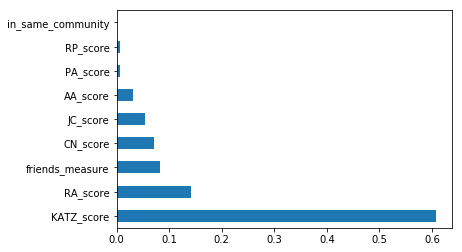

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

In [0]:
import seaborn as sns

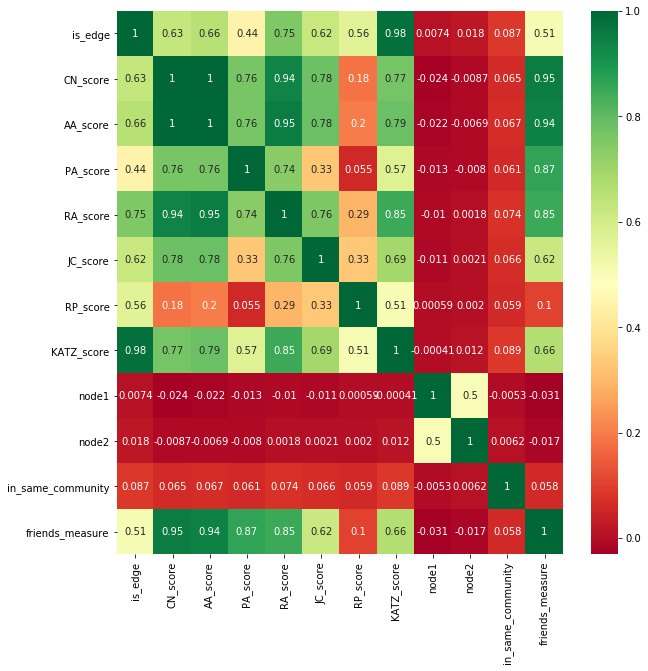

In [0]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
X_d = X[['RP_score', 'AA_score']]

In [250]:
X_d

,RP_score,AA_score
0,0.025711,0.113913
1,0.032904,0.043699
2,0.020491,0.396604
3,0.001535,0.000000
4,0.017878,0.150608
5,0.002772,0.004746
6,0.002970,0.003975
7,0.004211,0.021325
8,0.003141,0.008318
9,0.004076,0.008335


In [0]:
y_d = y


In [0]:
y_d

In [251]:
kfold = model_selection.KFold(n_splits=5, random_state=22, shuffle = True)
model_kfold = DecisionTreeClassifier(random_state=0)
results_kfold = model_selection.cross_val_score(model_kfold, X_d, y_d, cv=5, scoring='roc_auc')
print(results_kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

[0.99944737 0.99944737 0.99961741 0.99927733 0.99961741]
Accuracy: 99.95%


In [0]:
df[['KATZ_score', 'is_same']]